In [2]:
import torch
import torchani
from torchani.datasets import ANIDataset
from torchani.units import hartree2kcalpermol
from torchani.utils import PERIODIC_TABLE
import ase
from ase import io
from ase.optimize import BFGS
from ase.visualize import view

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [3]:
def tensors_from_xyz(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        coordinates = []
        species = []
        element, a, b, c = lines[2].split()
        cell = torch.diag(torch.tensor([float(a), float(b), float(c)]))
        for line in lines[2:]:
            values = line.split()
            if values:
                s = values[0].strip()
                x = float(values[1])
                y = float(values[2])
                z = float(values[3])
                coordinates.append([x, y, z])
                species.append(PERIODIC_TABLE.index(s))
        coordinates = torch.tensor(coordinates)
        species = torch.tensor(species, dtype=torch.long)
        assert coordinates.shape[0] == num_atoms
        assert species.shape[0] == num_atoms
    return species, coordinates



def covariances(atomic_energies):
    atomic_energies = atomic_energies.squeeze()
    cov = np.cov(atomic_energies,rowvar=False)
    atomic_variances = cov.diagonal()
    av_sum = atomic_variances.sum()
    atomic_stdev = np.sqrt(atomic_variances)
    estimated_qbc = np.sqrt(sum(sum(cov)))/np.sqrt(len(atomic_variances))
    
    just_covariances = estimated_qbc - np.sum(atomic_variances)
    
    qbc = atomic_energies.sum(1).std(0,ddof=1)/np.sqrt(len(atomic_variances)) # TorchANI uses unbiased stdev, so N-1
    
    
    assert math.isclose(qbc, estimated_qbc, abs_tol=0.0002) # Tolerance set to agree within 0.0002 Hartree (~.12 kcal/mol))

    print('(1) Atomic energy variance', '(2) Covariances', '(3) QBC')
    
    return av_sum, just_covariances, qbc

device = torch.device('cpu')
model = torchani.models.ANI2xr()
calculator = model.ase()

In [4]:
ds_path = Path('/Users/nickterrel/.local/share/torchani/Datasets/ANI-1x-first-conformers.h5')

ds = ANIDataset(locations=ds_path, names='1x first')
device = torch.device('cpu')
ani2xr = torchani.models.ANI2xr().double()
calculator = torchani.models.ANI2xr().ase()

In [5]:
path = Path('./c5h12.xyz')
c5h12 = tensors_from_xyz(path)

In [6]:
ase_c5h12 = ase.Atoms(numbers=tensors_from_xyz(path)[0],positions=tensors_from_xyz(path)[1])
ase_c5h12.calc = calculator
#print(ase_c5h12.positions)

dyn = BFGS(ase_c5h12)
dyn.run(fmax=0.0005)


c5h12_species = torch.tensor(ase_c5h12.numbers[None])
c5h12_coord = torch.tensor(ase_c5h12.positions[None])
c5h12 = (c5h12_species, c5h12_coord)
#print(ase_c5h12.positions)

      Step     Time          Energy          fmax
BFGS:    0 20:30:04    -5380.202148        0.083460
BFGS:    1 20:30:04    -5380.202637        0.024285
BFGS:    2 20:30:04    -5380.202637        0.020974
BFGS:    3 20:30:04    -5380.202637        0.021619
BFGS:    4 20:30:04    -5380.202637        0.019243
BFGS:    5 20:30:04    -5380.202637        0.011195
BFGS:    6 20:30:04    -5380.202637        0.011082
BFGS:    7 20:30:04    -5380.202637        0.005657
BFGS:    8 20:30:04    -5380.202637        0.001230
BFGS:    9 20:30:04    -5380.202637        0.000094


In [7]:
c5h12

(tensor([[6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 tensor([[[-1.5932e+00,  4.7584e-01,  4.8789e-07],
          [-6.0424e-02,  4.7584e-01, -8.4279e-09],
          [-2.1042e+00, -7.2465e-01,  8.0454e-01],
          [-2.1042e+00,  3.7932e-01, -1.4419e+00],
          [-2.1042e+00,  1.7728e+00,  6.3738e-01],
          [-1.7531e+00, -5.4143e-01, -1.9241e+00],
          [-1.7531e+00,  1.2276e+00, -2.0425e+00],
          [-3.2008e+00,  3.7727e-01, -1.4726e+00],
          [-1.7531e+00, -1.6689e+00,  3.7017e-01],
          [-3.2008e+00, -7.5017e-01,  8.2165e-01],
          [-1.7531e+00, -6.8181e-01,  1.8430e+00],
          [ 3.3407e-01, -4.4286e-01, -4.5147e-01],
          [ 3.3407e-01,  5.4420e-01,  1.0214e+00],
          [ 3.3407e-01,  1.3262e+00, -5.6988e-01],
          [-1.7531e+00,  1.8688e+00,  1.6723e+00],
          [-3.2008e+00,  1.8004e+00,  6.5093e-01],
          [-1.7531e+00,  2.6507e+00,  8.1045e-02]]], dtype=torch.float64))

In [8]:
# Must use 'model.set_enabled("energy_shifter", False)' to get output w/o GSAEs
ani2xr.set_enabled("energy_shifter", False)
# Atomic energy, then sum over 
hartree2kcalpermol(ani2xr.atomic_energies(c5h12,ensemble_values=True).energies)

tensor([[[-206.2197, -212.5720, -212.5720, -212.5720, -212.5720,  -45.7268,
           -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268,
           -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268]],

        [[-194.2755, -191.5728, -191.5728, -191.5728, -191.5728,  -53.6970,
           -53.6969,  -53.6970,  -53.6969,  -53.6970,  -53.6970,  -53.6970,
           -53.6970,  -53.6970,  -53.6970,  -53.6970,  -53.6969]],

        [[-193.9204, -192.1621, -192.1621, -192.1621, -192.1621,  -53.5538,
           -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538,
           -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538]],

        [[-196.2010, -198.0324, -198.0324, -198.0324, -198.0324,  -51.3933,
           -51.3933,  -51.3933,  -51.3933,  -51.3934,  -51.3933,  -51.3933,
           -51.3933,  -51.3933,  -51.3933,  -51.3933,  -51.3933]],

        [[-194.6576, -192.6317, -192.6317, -192.6317, -192.6317,  -53.3212,
           -53.3212,  -53.3212,  -53.3212,  

In [9]:
hartree2kcalpermol(ani2xr.atomic_energies(c5h12,ensemble_values=True).energies.std(0))

tensor([[4.4739, 8.9236, 8.9236, 8.9236, 8.9236, 3.3174, 3.3174, 3.3174, 3.3174,
         3.3174, 3.3174, 3.3174, 3.3174, 3.3174, 3.3174, 3.3174, 3.3174]],
       dtype=torch.float64)

In [10]:
hartree2kcalpermol(ani2xr.atomic_energies(c5h12,ensemble_values=True).energies)

tensor([[[-206.2197, -212.5720, -212.5720, -212.5720, -212.5720,  -45.7268,
           -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268,
           -45.7268,  -45.7268,  -45.7268,  -45.7268,  -45.7268]],

        [[-194.2755, -191.5728, -191.5728, -191.5728, -191.5728,  -53.6970,
           -53.6969,  -53.6970,  -53.6969,  -53.6970,  -53.6970,  -53.6970,
           -53.6970,  -53.6970,  -53.6970,  -53.6970,  -53.6969]],

        [[-193.9204, -192.1621, -192.1621, -192.1621, -192.1621,  -53.5538,
           -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538,
           -53.5538,  -53.5538,  -53.5538,  -53.5538,  -53.5538]],

        [[-196.2010, -198.0324, -198.0324, -198.0324, -198.0324,  -51.3933,
           -51.3933,  -51.3933,  -51.3933,  -51.3934,  -51.3933,  -51.3933,
           -51.3933,  -51.3933,  -51.3933,  -51.3933,  -51.3933]],

        [[-194.6576, -192.6317, -192.6317, -192.6317, -192.6317,  -53.3212,
           -53.3212,  -53.3212,  -53.3212,  

In [11]:
# Total energy per model
hartree2kcalpermol(ani2xr(c5h12, ensemble_values=True).energies)

tensor([[-1605.2294],
        [-1604.9303],
        [-1605.2143],
        [-1605.0505],
        [-1605.0391],
        [-1604.9653],
        [-1605.3038],
        [-1604.5538]], dtype=torch.float64)

In [12]:
hartree2kcalpermol(ani2xr(c5h12).energies)

tensor([-1605.0358], dtype=torch.float64)

In [13]:
c5h12_ae = hartree2kcalpermol(ani2xr.atomic_energies(c5h12,ensemble_values=True).energies.squeeze().detach().numpy())
print(c5h12_ae)

[[-206.21965524 -212.57199659 -212.57198506 -212.57198788 -212.571985
   -45.72681538  -45.72680268  -45.72683464  -45.7268056   -45.72684194
   -45.72681235  -45.72681445  -45.72681209  -45.72681952  -45.72683111
   -45.7268265   -45.7267974 ]
 [-194.2755117  -191.57283751 -191.5728365  -191.57283119 -191.57283349
   -53.69695356  -53.69694406  -53.69696725  -53.69694495  -53.69697387
   -53.69695019  -53.69695141  -53.69695019  -53.69695647  -53.69696668
   -53.69696072  -53.69693863]
 [-193.92039065 -192.16214112 -192.16214328 -192.16213622 -192.16213956
   -53.55377696  -53.55376977  -53.55379142  -53.55377015  -53.55379658
   -53.5537745   -53.55377675  -53.5537739   -53.5537809   -53.55378945
   -53.55378492  -53.55376448]
 [-196.20098916 -198.0323786  -198.03237583 -198.03237298 -198.0323737
   -51.39333449  -51.39332561  -51.39334957  -51.39332613  -51.39335645
   -51.3933313   -51.39333327  -51.39333088  -51.39333861  -51.39334863
   -51.39334274  -51.3933197 ]
 [-194.65760713

In [14]:
c5h12_ae.shape

(8, 17)

In [15]:
c5h12_ae.sum(1).std(0,ddof=0)

0.22075329676789401

In [16]:
hartree2kcalpermol(ani2xr.energies_qbcs(c5h12).qbcs.item()*math.sqrt(5))
# Equal up to float rounding precision

0.12798636749073233

In [17]:
print(covariances(c5h12_ae))

(1) Atomic energy variance (2) Covariances (3) QBC
(470.6013357324946, -470.54409848891413, 0.05723724358054595)


In [18]:
hartree2kcalpermol(ani2xr(c5h12, ensemble_values=True).energies.std(0).detach().numpy())

array([0.2359952])

[[ 20.01617509  37.13989246  37.13987369  37.13988832  37.13987956
  -14.01691373 -14.01692044 -14.01690377 -14.01691597 -14.01690185
  -14.01691273 -14.01691206 -14.01691274 -14.0169117  -14.01690834
  -14.01690654 -14.01691998]
 [ 37.13989246  79.63115525  79.63112392  79.6311501   79.63113558
  -29.57813119 -29.5781418  -29.57810944 -29.57813298 -29.57810786
  -29.57812736 -29.57812472 -29.57812804 -29.57812572 -29.57812127
  -29.57811509 -29.57814052]
 [ 37.13987369  79.63112392  79.63109258  79.63111877  79.63110425
  -29.5781192  -29.57812981 -29.57809744 -29.57812098 -29.57809587
  -29.57811536 -29.57811272 -29.57811605 -29.57811373 -29.57810928
  -29.5781031  -29.57812853]
 [ 37.13988832  79.6311501   79.63111877  79.63114495  79.63113043
  -29.57812913 -29.57813974 -29.57810738 -29.57813092 -29.5781058
  -29.5781253  -29.57812266 -29.57812598 -29.57812367 -29.57811921
  -29.57811303 -29.57813847]
 [ 37.13987956  79.63113558  79.63110425  79.63113043  79.63111591
  -29.57812357

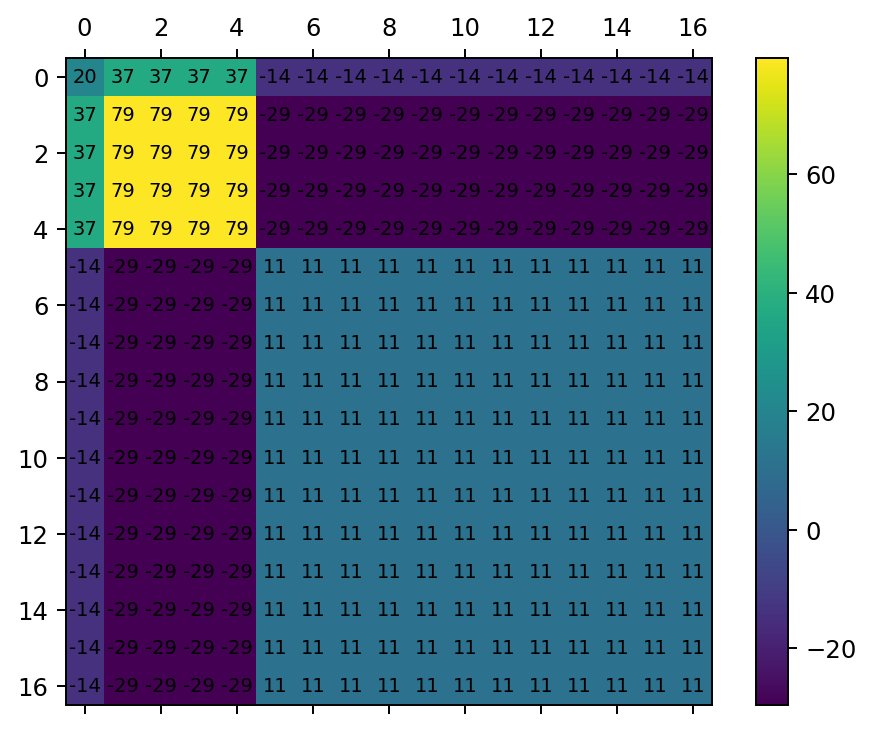

In [19]:
c5h12_cov = np.cov(c5h12_ae,rowvar=False)
print(c5h12_cov)
print('Covariance matrix:\n',pd.DataFrame(c5h12_cov))
atomic_variances = c5h12_cov.diagonal()
atomic_stdev = np.sqrt(atomic_variances)
print()
print('AE variance (stdev squared):\n',atomic_variances)
print('Sum of AE stdev:\n',np.sum(atomic_stdev))
print()

sqrt_sum_cov = np.sqrt(sum(sum(c5h12_cov)))
c5h12_qbc = hartree2kcalpermol(ani2xr(c5h12, ensemble_values=True).energies.std(0).detach().numpy())
only_covariances = sqrt_sum_cov - np.sum(atomic_stdev)

print('Sum of covariances (off-diagonal elements):\n',only_covariances)

print('QBC from ANI (w/o dividing by N_atoms):\n',c5h12_qbc,'(kcal/mol)')
print('Sqrt of the sum over entire covariance matrix:\n',sqrt_sum_cov,'(kcal/mol)')

plt.rcParams['figure.dpi'] = 175

fig, ax = plt.subplots()
img = ax.matshow(c5h12_cov)#, cmap='seismic_r')
fig.colorbar(img)

for (i, j), z in np.ndenumerate(c5h12_cov):
    ax.text(j, i, f'{int(z)}', ha='center', va='center', fontweight=500, fontsize=8)

plt.savefig('./c5h12_covariance.png')

In [28]:
c5h12_cov

array([[ 20.01617509,  37.13989246,  37.13987369,  37.13988832,
         37.13987956, -14.01691373, -14.01692044, -14.01690377,
        -14.01691597, -14.01690185, -14.01691273, -14.01691206,
        -14.01691274, -14.0169117 , -14.01690834, -14.01690654,
        -14.01691998],
       [ 37.13989246,  79.63115525,  79.63112392,  79.6311501 ,
         79.63113558, -29.57813119, -29.5781418 , -29.57810944,
        -29.57813298, -29.57810786, -29.57812736, -29.57812472,
        -29.57812804, -29.57812572, -29.57812127, -29.57811509,
        -29.57814052],
       [ 37.13987369,  79.63112392,  79.63109258,  79.63111877,
         79.63110425, -29.5781192 , -29.57812981, -29.57809744,
        -29.57812098, -29.57809587, -29.57811536, -29.57811272,
        -29.57811605, -29.57811373, -29.57810928, -29.5781031 ,
        -29.57812853],
       [ 37.13988832,  79.6311501 ,  79.63111877,  79.63114495,
         79.63113043, -29.57812913, -29.57813974, -29.57810738,
        -29.57813092, -29.5781058 ,

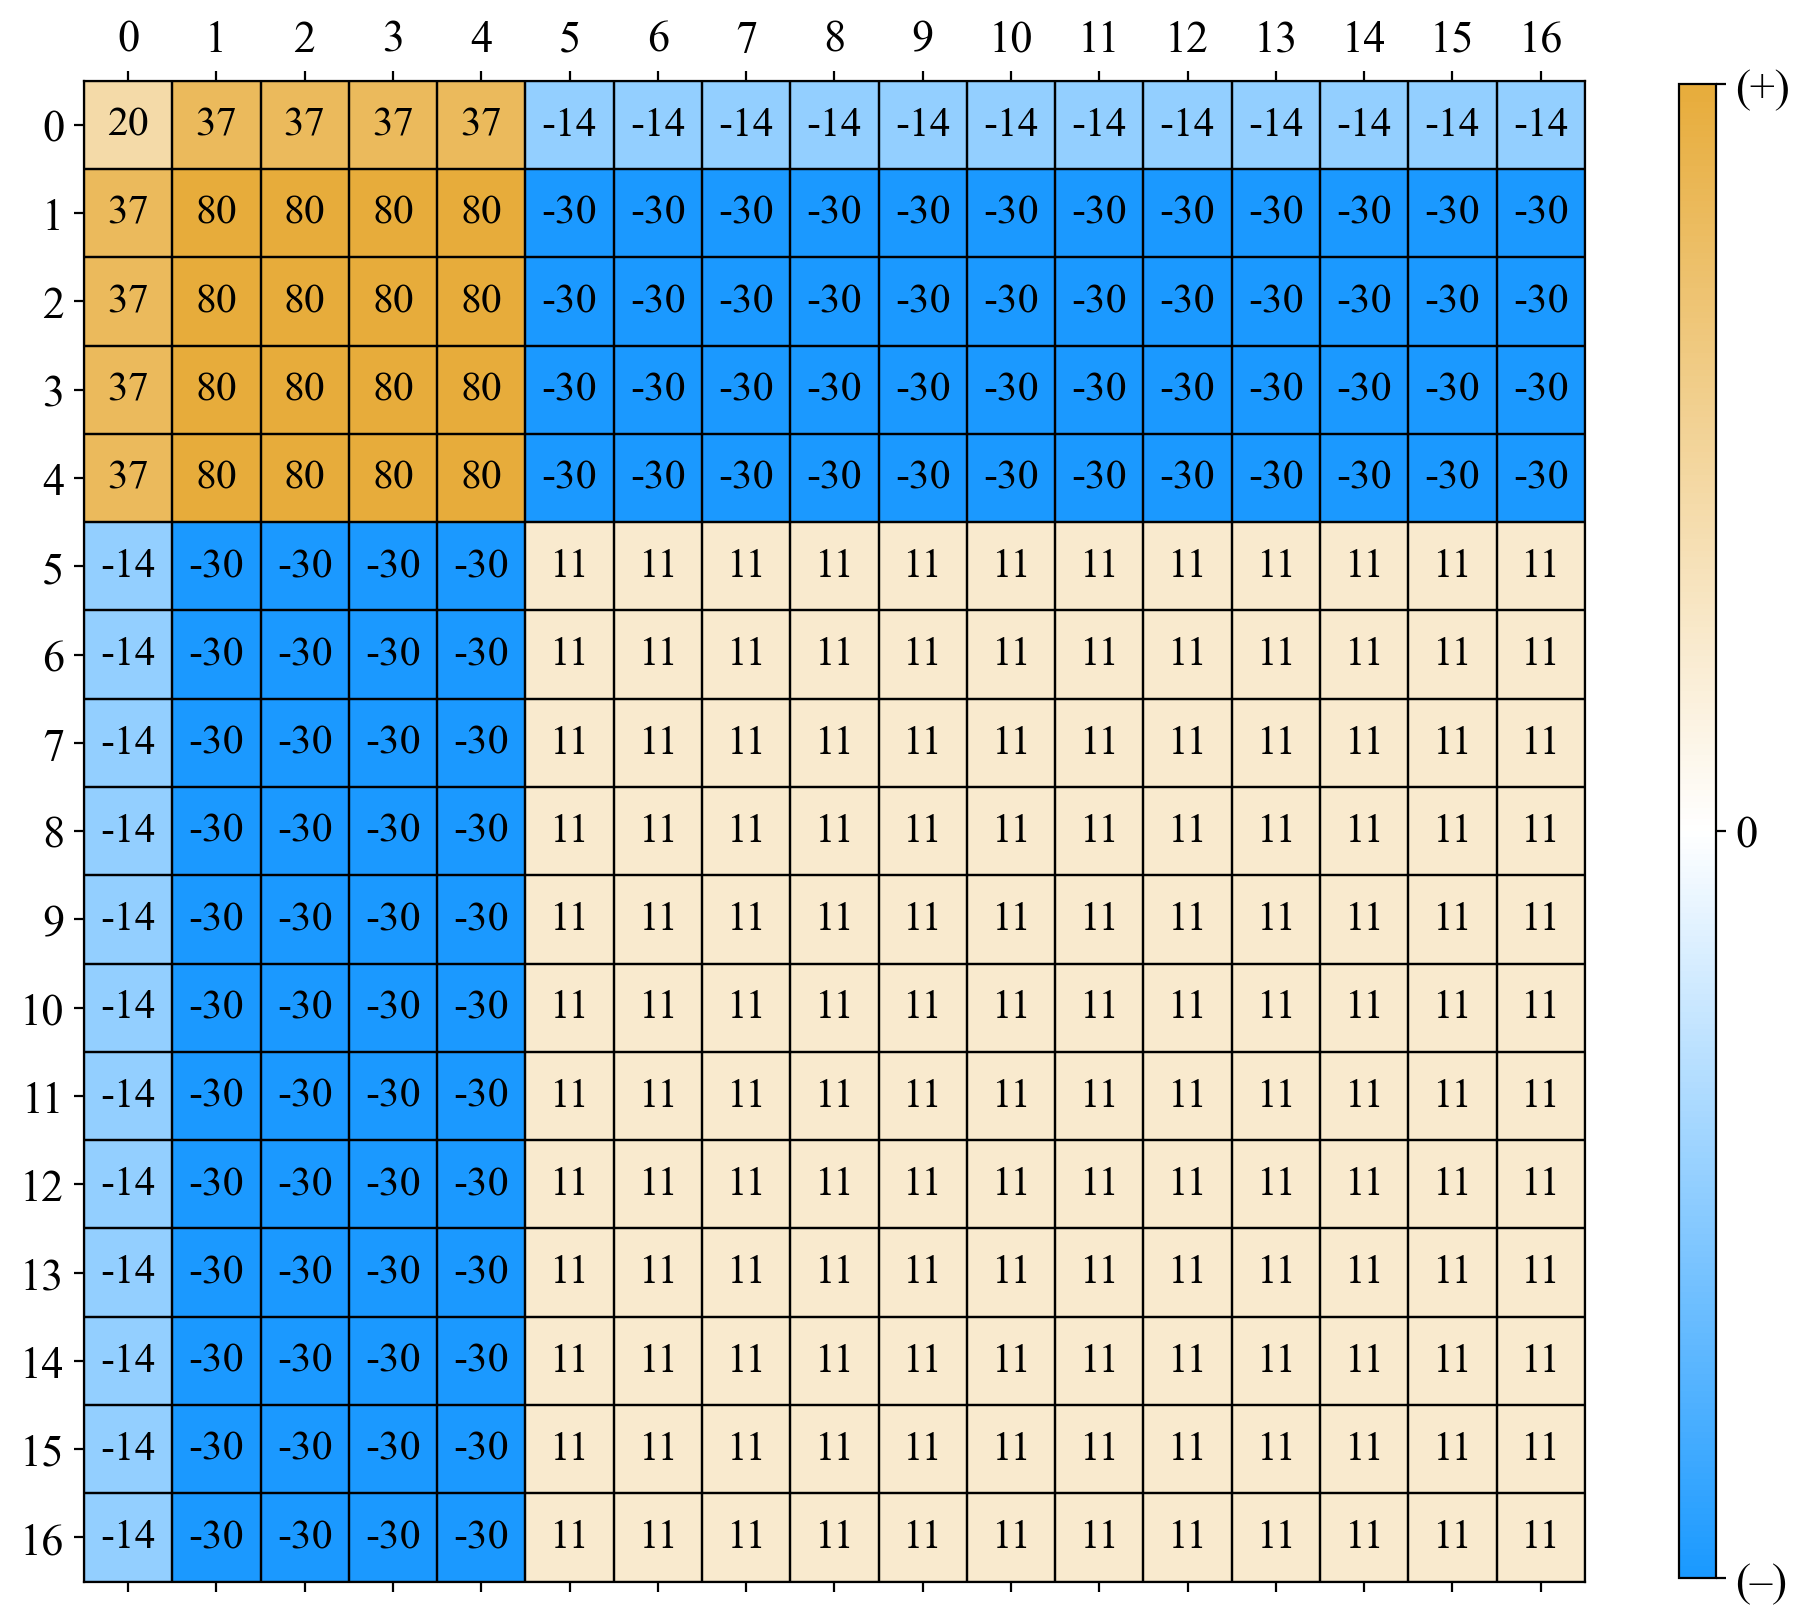

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches  # Import patches for outlining

plt.rcParams['font.family'] = 'Times New Roman'

# Your covariance matrix
c5h12_cov = np.cov(c5h12_ae, rowvar=False)

# Define custom colormap with the new orange shade
clist = [
    (0.1, 0.6, 1.0),  # Blue for negative values
    (1.0, 1.0, 1.0),  # White at zero
    (231/255, 172/255, 59/255)  # New bright orange for positive values
]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)

# Normalize values with a new scale to make 80 stand out
norm = mcolors.TwoSlopeNorm(vmin=-30, vcenter=0, vmax=45)  # Adjusted from -20 to 20 → Now -30 to 45

# Create figure
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the covariance matrix with the updated colormap
img = ax.matshow(c5h12_cov, cmap=cmap, norm=norm)
cbar = fig.colorbar(img, shrink=0.77, aspect=40)

# Customize color bar
cbar.set_ticks([-30, 0, 45])  # Set new range
cbar.ax.set_yticklabels(['(–)', '0', '(+)'], fontsize=16, fontweight='normal')  # Label the colors

# Annotate each cell with integer values and outline with black border
for (i, j), z in np.ndenumerate(c5h12_cov):
    ax.text(j, i, '{:d}'.format(int(round(z))), ha='center', va='center', fontweight=500, fontsize=15)
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=0.8, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Adjust tick labels on the axes
ax.set_xticks(range(c5h12_cov.shape[1]))
ax.set_yticks(range(c5h12_cov.shape[0]))
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
# Save figure
plt.savefig('./c5h12_covariance_golden_orange_adjusted.png')

plt.show()

In [43]:
hartree2kcalpermol(covariances(c5h12_ae)[2]/math.sqrt(5))

(1) Atomic energy variance (2) Covariances (3) QBC


16.062531625847473

In [23]:
print('Mol_E stdev:',ani2xr.energies_qbcs(ch4).qbcs.item()*math.isqrt(5))
print('Atom_E stdev:',torch.tensor(ch4_ae).std(0, unbiased=True))
print('Sum of AE_std:',torch.tensor(ch4_ae).std(0, unbiased=True).sum(0))
print()
print('Covariance matrix:\n',ch4_cov)
print('Diagonal of cov matrix:\n',ch4_cov.diagonal()) # This gives "variances"


NameError: name 'ch4' is not defined

In [38]:
ch4_ae

array([[-219.43191773,  -50.00009135,  -50.03382141,  -50.02904322,
         -50.00271756],
       [-194.71161625,  -56.18610887,  -56.21296353,  -56.20352363,
         -56.19027869],
       [-192.88231548,  -56.63473898,  -56.65781144,  -56.65355779,
         -56.6368453 ],
       [-201.56722612,  -54.43014634,  -54.46050759,  -54.45343689,
         -54.43356306],
       [-196.52156401,  -55.69160292,  -55.72140463,  -55.71330989,
         -55.69537748],
       [-212.93089617,  -51.57885894,  -51.61024281,  -51.60481557,
         -51.58170645],
       [-186.56354095,  -58.18695209,  -58.2175399 ,  -58.20561715,
         -58.19218979],
       [-187.44227916,  -57.9894555 ,  -58.00998517,  -58.00754064,
         -57.99083344]])

In [49]:
covariances(ch4_ae)

(1) Atomic energy variance (2) Covariances (3) QBC


(172.93134613636664, -172.89674797886335, 0.03459815750324223)